In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Introduction
* Finding the relationship between the composition/structure and properties of materials is a holy grail of material science. Various models ranging from QM methods on the atomic scale to FEM on the macroscopic scale have been developed in the past century. More recently, ML-based approaches have gained momentum.
* Here, we provide a toy dataset of alloys toy_alloy_data.csv. The first 12 columns correspond to the proportion of 12 elements (i.e. the first 12 columns of any row should sum to 1). The last 6 columns correspond to 6 properties (Each property column has been normalised so that its mean and standard deviation are 0 and 1, respectively)
* We will analyze the data and use various Machine Learning techniques to solve the tasks in hand.

#### Read and store data

In [24]:
toy_alloy_data = pd.read_csv("toy_alloy_data.csv")
size = len(toy_alloy_data)

X_name = [f'element {i}' for i in range(1,13)]
Y_name = [f'property {i}' for i in range(1,7)]
print(toy_alloy_data)

      element 1  element 2  element 3  element 4  element 5  element 6  \
0      0.693551   0.199083   0.055558   0.032409   0.009260   0.009260   
1      0.009337   0.000000   0.009337   0.308123   0.000000   0.659197   
2      0.956573   0.009781   0.008803   0.000000   0.016628   0.000978   
3      0.301588   0.253547   0.013345   0.400338   0.017793   0.006672   
4      0.946832   0.000000   0.008616   0.037207   0.004406   0.000000   
...         ...        ...        ...        ...        ...        ...   
4607   0.004012   0.000000   0.000000   0.006018   0.002006   0.980943   
4608   0.002485   0.000000   0.000298   0.000000   0.001988   0.000398   
4609   0.000484   0.000000   0.000000   0.000000   0.000000   0.677310   
4610   0.697464   0.209334   0.057091   0.018079   0.009515   0.007612   
4611   0.004004   0.000000   0.000000   0.006006   0.002002   0.980981   

      element 7  element 8  element 9  element 10  element 11  element 12  \
0      0.000324   0.000278   0.000

In [25]:
toy_alloy_data.describe()

,element 1,element 2,element 3,element 4,element 5,element 6,element 7,element 8,element 9,element 10,element 11,element 12,property 1,property 2,property 3,property 4,property 5,property 6
count,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4.612000e+03,4.612000e+03,4.612000e+03,4.612000e+03,4.612000e+03,4.612000e+03
mean,0.419336,0.040728,0.009421,0.042242,0.007931,0.203768,0.000311,0.001710,0.000181,0.032633,0.001262,0.240479,-3.191470e-16,-4.357120e-17,8.902005e-17,-1.714683e-16,-1.644965e-13,-3.322003e-17
std,0.435785,0.076945,0.016830,0.115915,0.016362,0.362367,0.000952,0.004197,0.000389,0.104186,0.001974,0.411919,1.000108e+00,1.000108e+00,1.000108e+00,1.000108e+00,1.000108e+00,1.000108e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.082560e-01,-1.148295e+00,-2.919913e+00,-9.310694e-01,-2.724788e+01,-1.207390e+00
25%,0.003968,0.000000,0.000991,0.000000,0.000996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.082560e-01,-1.044864e+00,-4.468705e-01,-9.240504e-01,1.750028e-02,-8.248388e-01
50%,0.051852,0.001395,0.007878,0.000000,0.003957,0.002470,0.000237,0.000201,0.000090,0.000000,0.000000,0.000000,-1.082560e-01,-4.368803e-01,1.533713e-01,-6.737728e-01,2.279300e-02,-1.572499e-01
75%,0.948544,0.013826,0.010929,0.016726,0.008841,0.049140,0.000349,0.001947,0.000281,0.002451,0.001513,0.389568,-9.935497e-02,1.192823e+00,8.322118e-01,1.285551e+00,2.367406e-02,5.178401e-01
max,0.999350,0.581123,0.413413,0.986388,0.190476,1.000000,0.015780,0.037486,0.006713,0.999920,0.014677,0.996910,5.467245e+01,1.315811e+00,8.443982e-01,1.430488e+00,3.963239e+01,1.229441e+01


### Task 1: Handling missing data

For each row, the sum of proportion of elements should be equal to 1. Therefore, for a missing value of element X, we can replace it the following way:

Let in ith row, element X is missing. Let mean of X over all data = m.

Let sum of all other elements in that row be s.

replace Xth cell of ith row by m*(1-s)/sum(mean of all missing elements)

Missing values of properties can be replaced by their mean over all data.

##### Correlation heatmap of input features

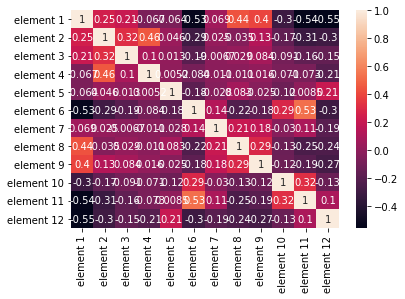

In [26]:
in_df = toy_alloy_data[X_name]
corrMatrix = in_df.corr()

sn.heatmap(corrMatrix, annot=True)
plt.show()

### Task 2: Predicting properties from composition of materials
* Here we show how to train a simple neural network model for the composition to property problem using PyTorch.

Note: In the code below, we did not split the data into training, validation and testing sets, which you probably should not do.

In [27]:
# a simple training procedure with MSE loss and Adam optimiser
def train(x, y,  max_iter=20000):
    # a simple MLP with three hidden layers and tanh activation
    m = nn.Sequential(nn.Linear(12, 12), nn.Tanh(), nn.Linear(12, 9), nn.Tanh(), nn.Linear(9, 6))
    m.double()
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(m.parameters())
    loss_hist = []
    R2_hist = []
    y_bar = torch.mean(y, 0)

    for t in range(1, max_iter + 1):
        y_pred = m(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 1000 == 0:
            loss_hist.append(loss.detach())
            R2 = 1 - torch.sum((y - y_pred)**2, 0) / torch.sum((y - y_bar)**2, 0)
            R2 = torch.mean(R2)
            R2_hist.append(R2.detach())
            print(f'epoch: {t}, loss: {float(loss.item()):.4f}, R^2: {float(R2):.4f}')
            if len(loss_hist) > 2 and torch.abs((loss_hist[-1]-loss_hist[-2])/loss_hist[-1]) < 1e-6:
                break
    return m, loss_hist, R2_hist

In [28]:
X = torch.tensor(toy_alloy_data[X_name].values)
Y = torch.tensor(toy_alloy_data[Y_name].values)

In [29]:
m, loss_hist, R2_hist= train(X, Y, max_iter=30000)

epoch: 1000, loss: 0.4918, R^2: 0.5082
epoch: 2000, loss: 0.4690, R^2: 0.5310
epoch: 3000, loss: 0.4545, R^2: 0.5455
epoch: 4000, loss: 0.4369, R^2: 0.5631
epoch: 5000, loss: 0.4009, R^2: 0.5991
epoch: 6000, loss: 0.3626, R^2: 0.6374
epoch: 7000, loss: 0.3341, R^2: 0.6659
epoch: 8000, loss: 0.3119, R^2: 0.6881
epoch: 9000, loss: 0.2980, R^2: 0.7020
epoch: 10000, loss: 0.2896, R^2: 0.7104
epoch: 11000, loss: 0.2834, R^2: 0.7166
epoch: 12000, loss: 0.2792, R^2: 0.7208
epoch: 13000, loss: 0.2761, R^2: 0.7239
epoch: 14000, loss: 0.2740, R^2: 0.7260
epoch: 15000, loss: 0.2719, R^2: 0.7281
epoch: 16000, loss: 0.2695, R^2: 0.7305
epoch: 17000, loss: 0.2668, R^2: 0.7332
epoch: 18000, loss: 0.2636, R^2: 0.7364
epoch: 19000, loss: 0.2592, R^2: 0.7408
epoch: 20000, loss: 0.2526, R^2: 0.7474
epoch: 21000, loss: 0.2437, R^2: 0.7563
epoch: 22000, loss: 0.2358, R^2: 0.7642
epoch: 23000, loss: 0.2289, R^2: 0.7711
epoch: 24000, loss: 0.2231, R^2: 0.7769
epoch: 25000, loss: 0.2184, R^2: 0.7816
epoch: 26

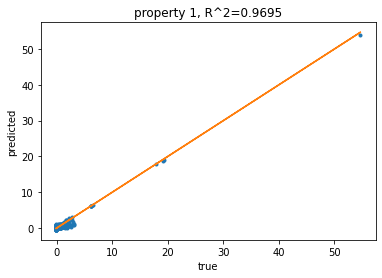

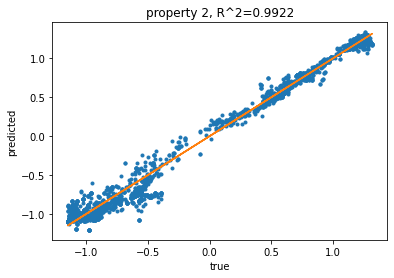

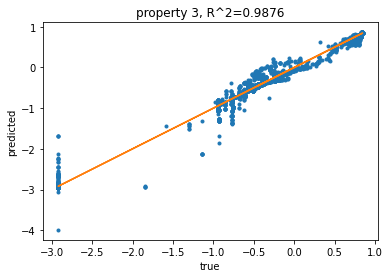

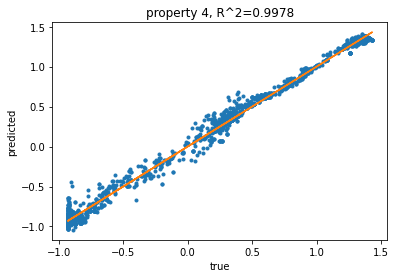

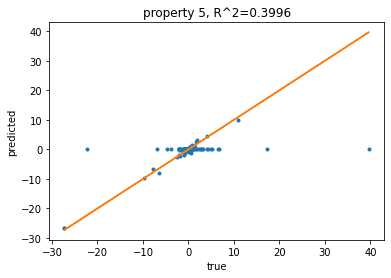

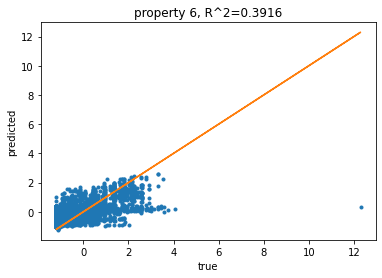

In [30]:
with torch.no_grad():
    Y_pred = m(X).numpy()
Y_true = Y.numpy()

for i in range(6):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()

The above code was provided to us by DeepVerse. The performance of the NN model above seems not too bad.
But, it can be improved by training the Neural Network model to predict for each property seperately. This means that our neural network will have 12 input features and 1 target value.
Here is the implementation of the above idea.

In [31]:
def train12to1(i, x, y,  max_iter=20000):
    
    m = nn.Sequential(nn.Linear(12, 12), nn.Tanh(), nn.Linear(12,6), nn.Tanh(), nn.Linear(6,1))
    m.double()
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(m.parameters())
    loss_hist = []
    R2_hist = []
    y_bar = torch.mean(y, 0)

    print(f'training for property {i}')
    for t in range(1, max_iter + 1):
        y_pred = m(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 1000 == 0:
            loss_hist.append(loss.detach())
            R2 = 1 - torch.sum((y - y_pred)**2, 0) / torch.sum((y - y_bar)**2, 0)
            R2 = torch.mean(R2)
            R2_hist.append(R2.detach())
            print(f'epoch: {t}, loss: {float(loss.item()):.4f}, R^2: {float(R2):.4f}')
            if len(loss_hist) > 2 and torch.abs((loss_hist[-1]-loss_hist[-2])/loss_hist[-1]) < 1e-6:
                break
    return m, loss_hist, R2_hist

In [32]:
X = torch.tensor(toy_alloy_data[X_name].values)
Y = torch.tensor(toy_alloy_data[Y_name].values)
Y_pred = np.empty((size, 6))

for i in range(6):
    target = [Y_name[i]]
    Y = torch.tensor(toy_alloy_data[target].values)
    m, loss_hist, R2_hist= train12to1(i+1, X, Y, max_iter=20000)
    with torch.no_grad():
        y_pred_i = m(X).numpy()
    for j in range(size):
        Y_pred[j][i] = y_pred_i[j]

training for property 0
epoch: 1000, loss: 0.8890, R^2: 0.1110
epoch: 2000, loss: 0.8406, R^2: 0.1594
epoch: 3000, loss: 0.7140, R^2: 0.2860
epoch: 4000, loss: 0.5309, R^2: 0.4691
epoch: 5000, loss: 0.3812, R^2: 0.6188
epoch: 6000, loss: 0.2662, R^2: 0.7338
epoch: 7000, loss: 0.1852, R^2: 0.8148
epoch: 8000, loss: 0.1173, R^2: 0.8827
epoch: 9000, loss: 0.0714, R^2: 0.9286
epoch: 10000, loss: 0.0475, R^2: 0.9525
epoch: 11000, loss: 0.0344, R^2: 0.9656
epoch: 12000, loss: 0.0274, R^2: 0.9726
epoch: 13000, loss: 0.0232, R^2: 0.9768
epoch: 14000, loss: 0.0201, R^2: 0.9799
epoch: 15000, loss: 0.0177, R^2: 0.9823
epoch: 16000, loss: 0.0158, R^2: 0.9842
epoch: 17000, loss: 0.0145, R^2: 0.9855
epoch: 18000, loss: 0.0136, R^2: 0.9864
epoch: 19000, loss: 0.0128, R^2: 0.9872
epoch: 20000, loss: 0.0121, R^2: 0.9879
training for property 1
epoch: 1000, loss: 0.0098, R^2: 0.9902
epoch: 2000, loss: 0.0044, R^2: 0.9956
epoch: 3000, loss: 0.0012, R^2: 0.9988
epoch: 4000, loss: 0.0009, R^2: 0.9991
epoch

#### Result

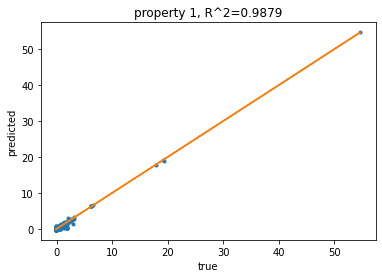

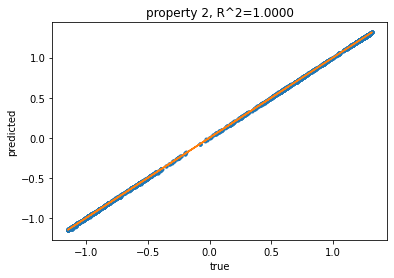

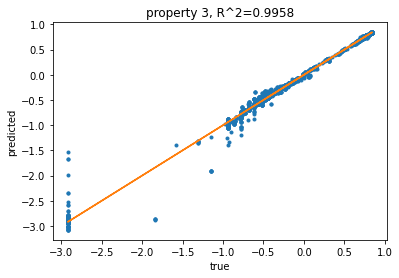

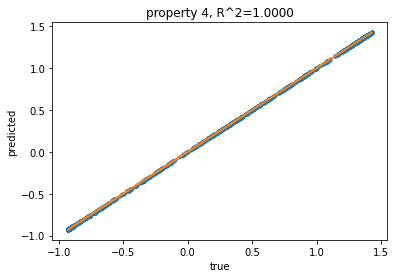

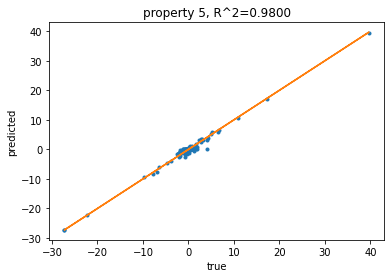

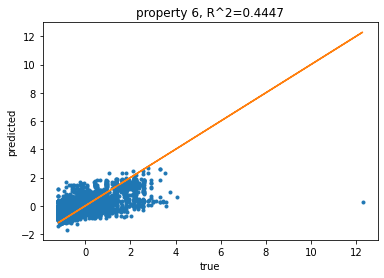

In [33]:
Y = torch.tensor(toy_alloy_data[Y_name].values)
Y_true = Y.numpy()

for i in range(6):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()

As you can see, the R-squared score has improved.

### Task 3: Predicting the composition of elements from the properties

Here we have used various machine learning models to predict the compositions.

Note that here, we have to compare the Regression models with the Neural Network models. Therefore we have no other choice but to split the data into training and testing data in a ratio 75:25.
I have also provided a notebook DeepVerse_Challenege-2.ipynb where I have trained the models on the whole dataset. For results on the complete dataset, please refer to DeepVerse_Challenege-2.ipynb

In [43]:
Y_name = [f'element {i}' for i in range(1,13)]
X_name = [f'property {i}' for i in range(1,7)]

train_size = int(0.75*size)
train_data = toy_alloy_data[:train_size]
test_data = toy_alloy_data[train_size:]

##### Correlation heatmap of input features

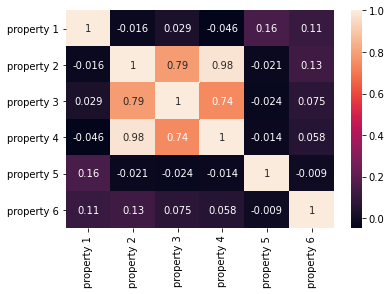

In [44]:
in_df = toy_alloy_data[X_name]
corrMatrix = in_df.corr()

sn.heatmap(corrMatrix, annot=True)
plt.show()

In [45]:
# helper function
# normalizes the predicted composition of each element to within the range 0 to 1
def normalize_results(Y):
    for i in range(len(Y)):
        sum = 0
        for j in range(len(Y[0])):
            if Y[i][j] < 0:
                Y[i][j] = 0
            sum = sum + Y[i][j]
        for j in range(len(Y[0])):
            Y[i][j] = Y[i][j]/sum
    return Y

#### Model 1: Simple Neural Network with 6 input features and 12 output features

In [46]:
# a simple training procedure with MSE loss and Adam optimiser
def train6to12(x, y,  max_iter=20000):
    # a simple MLP with three hidden layers and tanh activation
    m = nn.Sequential(nn.Linear(6, 6), nn.Tanh(), nn.Linear(6, 15), nn.Tanh(), nn.Linear(15, 12))
    m.double()
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(m.parameters())
    loss_hist = []
    R2_hist = []
    y_bar = torch.mean(y, 0)

    for t in range(1, max_iter + 1):
        y_pred = m(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 1000 == 0:
            loss_hist.append(loss.detach())
            R2 = 1 - torch.sum((y - y_pred)**2, 0) / torch.sum((y - y_bar)**2, 0)
            R2 = torch.mean(R2)
            R2_hist.append(R2.detach())
            print(f'epoch: {t}, loss: {float(loss.item()):.8f}, R^2: {float(R2):.8f}')
            if len(loss_hist) > 2 and torch.abs((loss_hist[-1]-loss_hist[-2])/loss_hist[-1]) < 1e-6:
                break
    return m, loss_hist, R2_hist

In [47]:
trainX = torch.tensor(train_data[X_name].values)
testX = torch.tensor(test_data[X_name].values)
trainY = torch.tensor(train_data[Y_name].values)
testY = torch.tensor(test_data[Y_name].values)

In [48]:
m, loss_hist, R2_hist= train6to12(trainX, trainY, max_iter=30000)

epoch: 1000, loss: 0.00937622, R^2: -17.78414939
epoch: 2000, loss: 0.00798601, R^2: -3.88255056
epoch: 3000, loss: 0.00659561, R^2: -5.63237245
epoch: 4000, loss: 0.00588652, R^2: -9.94219879
epoch: 5000, loss: 0.00557049, R^2: -6.44338092
epoch: 6000, loss: 0.00531938, R^2: -2.60232673
epoch: 7000, loss: 0.00520771, R^2: -1.28403475
epoch: 8000, loss: 0.00510401, R^2: -1.72604556
epoch: 9000, loss: 0.00496468, R^2: -0.88020071
epoch: 10000, loss: 0.00486473, R^2: -0.27544078
epoch: 11000, loss: 0.00477990, R^2: -0.07802942
epoch: 12000, loss: 0.00465884, R^2: 0.42327886
epoch: 13000, loss: 0.00453577, R^2: 0.50335368
epoch: 14000, loss: 0.00446305, R^2: 0.58422489
epoch: 15000, loss: 0.00437977, R^2: 0.47850632
epoch: 16000, loss: 0.00427147, R^2: 0.49363206
epoch: 17000, loss: 0.00420043, R^2: 0.45939087
epoch: 18000, loss: 0.00414810, R^2: 0.56984161
epoch: 19000, loss: 0.00409523, R^2: 0.58319625
epoch: 20000, loss: 0.00403533, R^2: 0.55168379
epoch: 21000, loss: 0.00399331, R^2: 

MSE Train : 0.0036875896209797774
MSE Test : 0.00538211072160712
The following graphs are plotted for the results on the test set


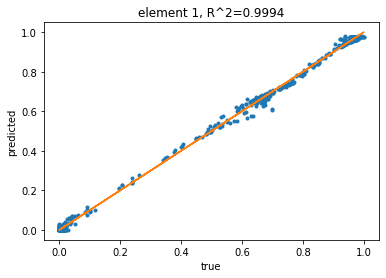

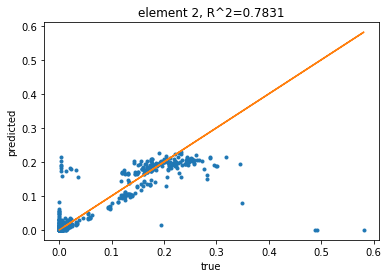

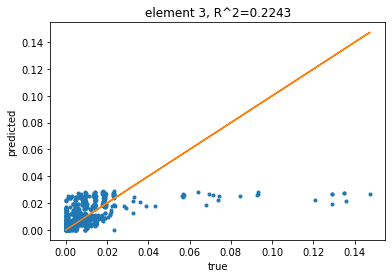

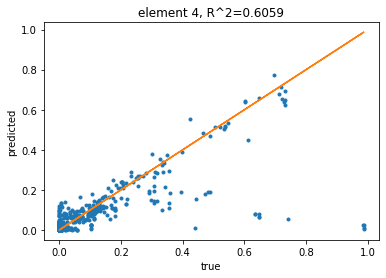

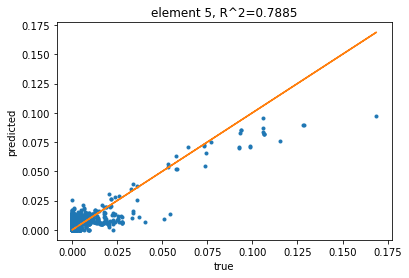

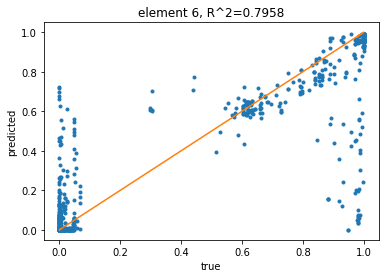

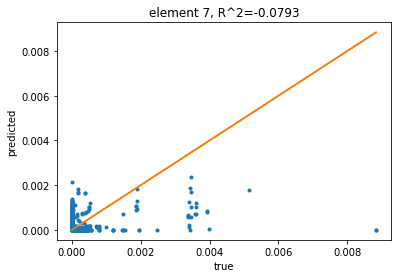

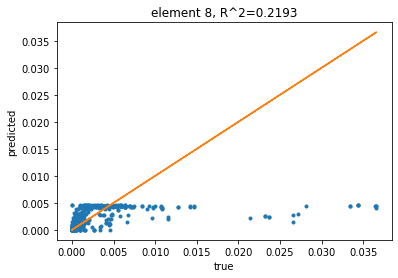

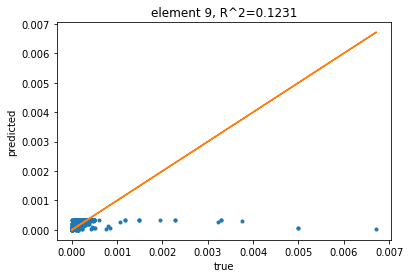

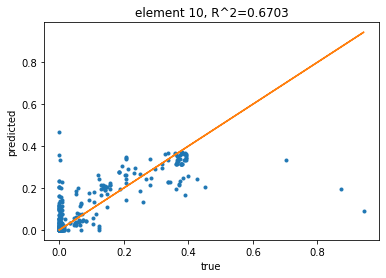

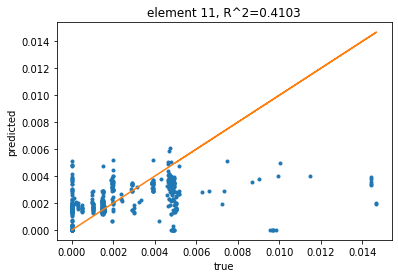

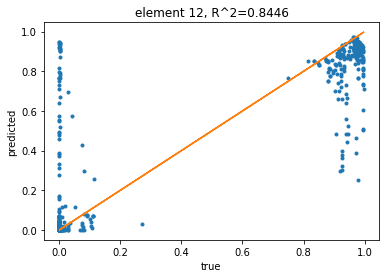

In [49]:
with torch.no_grad():
    Y_train_pred = m(trainX).numpy()
Y_train_true = trainY.numpy()

with torch.no_grad():
    Y_pred = m(testX).numpy()
Y_true = testY.numpy()

Y_pred = normalize_results(Y_pred)  #prediction on test data
Y_train_pred = normalize_results(Y_train_pred) #prediction on training data

print(f'MSE Train : {mean_squared_error(Y_train_true, Y_train_pred)}')    
print(f'MSE Test : {mean_squared_error(Y_true, Y_pred)}')    

print("The following graphs are plotted for the results on the test set")

for i in range(12):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()

#### Model 2: Simple Neural Network that predicts proportion of each element in the material seperately (i.e. 6 input features and 1 target value)

In [50]:
# a simple training procedure with MSE loss and Adam optimiser
def train6to1(i, x, y,  max_iter=20000):
    # a simple MLP with three hidden layers and tanh activation
    m = nn.Sequential(nn.Linear(6, 6), nn.Tanh(), nn.Linear(6, 3), nn.Tanh(), nn.Linear(3, 1))
    m.double()
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(m.parameters())
    loss_hist = []
    R2_hist = []
    y_bar = torch.mean(y, 0)
        
    print(f'training for element {i}')

    for t in range(1, max_iter + 1):
        y_pred = m(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 1000 == 0:
            loss_hist.append(loss.detach())
            R2 = 1 - torch.sum((y - y_pred)**2, 0) / torch.sum((y - y_bar)**2, 0)
            R2 = torch.mean(R2)
            R2_hist.append(R2.detach())
            print(f'epoch: {t}, loss: {float(loss.item()):.8f}, R^2: {float(R2):.8f}')
            if len(loss_hist) > 2 and torch.abs((loss_hist[-1]-loss_hist[-2])/loss_hist[-1]) < 1e-6:
                break
    return m, loss_hist, R2_hist

In [51]:
Y_train_pred = np.empty((train_size, 12)) #2darray that stores prediction on training data
Y_pred = np.empty((size-train_size, 12)) #2darray that stores prediction on test data

for i in range(12):
    target = [Y_name[i]]
    curr_Y = torch.tensor(train_data[target].values)
    m, loss_hist, R2_hist= train6to1(i+1, trainX, curr_Y, max_iter=30000)
    with torch.no_grad():
        y_train_pred_i = m(trainX).numpy()
    for j in range(train_size):
        Y_train_pred[j][i] = y_train_pred_i[j]
        
    with torch.no_grad():
        y_pred_i = m(testX).numpy()
    for j in range(size-train_size):
        Y_pred[j][i] = y_pred_i[j]

training for element 0
epoch: 1000, loss: 0.00167747, R^2: 0.99119470
epoch: 2000, loss: 0.00087456, R^2: 0.99540932
epoch: 3000, loss: 0.00057609, R^2: 0.99697603
epoch: 4000, loss: 0.00037548, R^2: 0.99802903
epoch: 5000, loss: 0.00020690, R^2: 0.99891394
epoch: 6000, loss: 0.00010669, R^2: 0.99943995
epoch: 7000, loss: 0.00005678, R^2: 0.99970193
epoch: 8000, loss: 0.00003439, R^2: 0.99981948
epoch: 9000, loss: 0.00002279, R^2: 0.99988038
epoch: 10000, loss: 0.00001625, R^2: 0.99991469
epoch: 11000, loss: 0.00001209, R^2: 0.99993653
epoch: 12000, loss: 0.00000976, R^2: 0.99994877
epoch: 13000, loss: 0.00000822, R^2: 0.99995683
epoch: 14000, loss: 0.00000713, R^2: 0.99996260
epoch: 15000, loss: 0.00000641, R^2: 0.99996636
epoch: 16000, loss: 0.00000895, R^2: 0.99995302
epoch: 17000, loss: 0.00000542, R^2: 0.99997156
epoch: 18000, loss: 0.00000516, R^2: 0.99997290
epoch: 19000, loss: 0.00000474, R^2: 0.99997511
epoch: 20000, loss: 0.00000451, R^2: 0.99997631
epoch: 21000, loss: 0.0000

epoch: 20000, loss: 0.02318595, R^2: 0.82291704
epoch: 21000, loss: 0.02305031, R^2: 0.82395303
epoch: 22000, loss: 0.02293516, R^2: 0.82483244
epoch: 23000, loss: 0.02284327, R^2: 0.82553425
epoch: 24000, loss: 0.02277164, R^2: 0.82608134
epoch: 25000, loss: 0.02271505, R^2: 0.82651356
epoch: 26000, loss: 0.02266850, R^2: 0.82686908
epoch: 27000, loss: 0.02262841, R^2: 0.82717526
epoch: 28000, loss: 0.02259364, R^2: 0.82744081
epoch: 29000, loss: 0.02256318, R^2: 0.82767347
epoch: 30000, loss: 0.02253526, R^2: 0.82788670
training for element 6
epoch: 1000, loss: 0.00008413, R^2: -77.25518546
epoch: 2000, loss: 0.00001183, R^2: -10.00272329
epoch: 3000, loss: 0.00000662, R^2: -5.15545187
epoch: 4000, loss: 0.00000425, R^2: -2.95550550
epoch: 5000, loss: 0.00000299, R^2: -1.77900520
epoch: 6000, loss: 0.00000226, R^2: -1.10267949
epoch: 7000, loss: 0.00000180, R^2: -0.67303160
epoch: 8000, loss: 0.00000136, R^2: -0.26907555
epoch: 9000, loss: 0.00000120, R^2: -0.12001145
epoch: 10000, l

epoch: 9000, loss: 0.02039819, R^2: 0.87960486
epoch: 10000, loss: 0.02000438, R^2: 0.88192921
epoch: 11000, loss: 0.01968389, R^2: 0.88382083
epoch: 12000, loss: 0.01924635, R^2: 0.88640329
epoch: 13000, loss: 0.01870729, R^2: 0.88958497
epoch: 14000, loss: 0.01835443, R^2: 0.89166766
epoch: 15000, loss: 0.01809305, R^2: 0.89321036
epoch: 16000, loss: 0.01775948, R^2: 0.89517916
epoch: 17000, loss: 0.01749194, R^2: 0.89675827
epoch: 18000, loss: 0.01726476, R^2: 0.89809911
epoch: 19000, loss: 0.01705199, R^2: 0.89935497
epoch: 20000, loss: 0.01663686, R^2: 0.90180516
epoch: 21000, loss: 0.01625925, R^2: 0.90403391
epoch: 22000, loss: 0.01598419, R^2: 0.90565738
epoch: 23000, loss: 0.01574232, R^2: 0.90708493
epoch: 24000, loss: 0.01553602, R^2: 0.90830258
epoch: 25000, loss: 0.01536440, R^2: 0.90931550
epoch: 26000, loss: 0.01523276, R^2: 0.91009252
epoch: 27000, loss: 0.01513020, R^2: 0.91069784
epoch: 28000, loss: 0.01504964, R^2: 0.91117333
epoch: 29000, loss: 0.01498454, R^2: 0.91

MSE Train : 0.0032027635944287293
MSE Test : 0.005353191772682098
The following graphs are plotted for the results on the test set


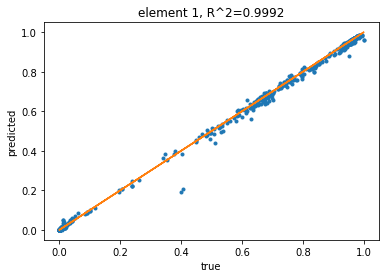

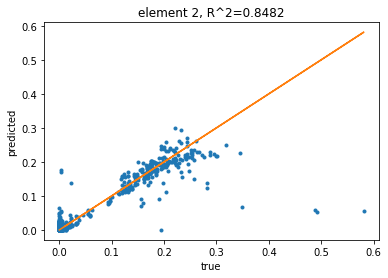

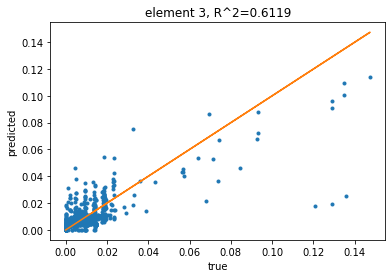

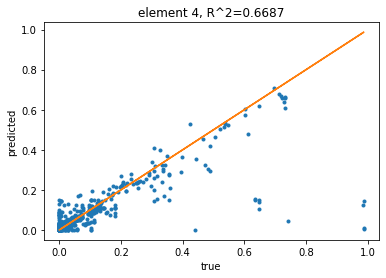

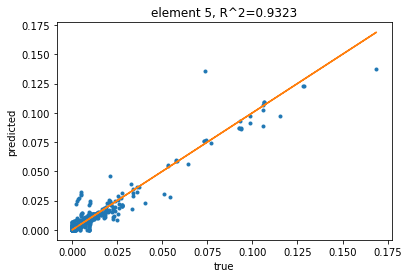

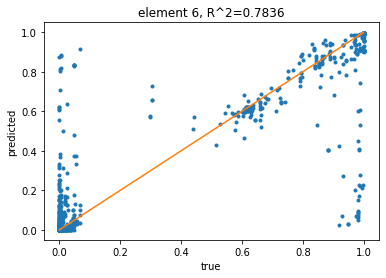

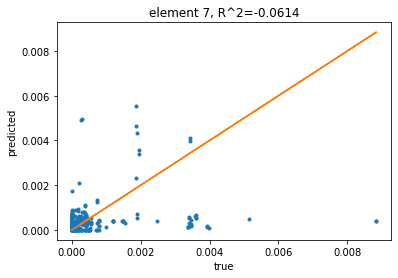

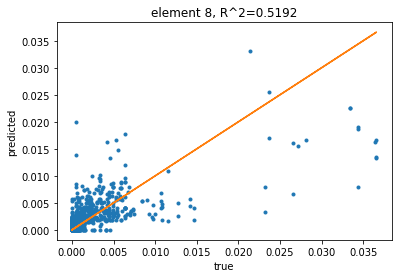

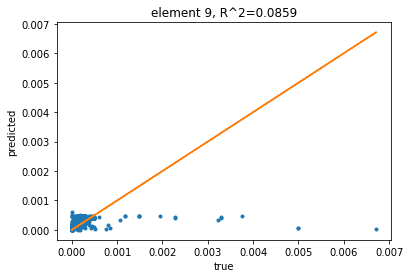

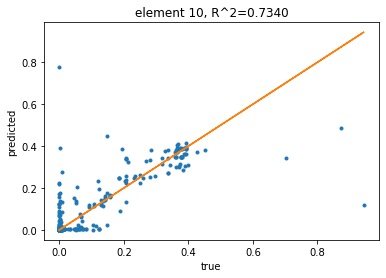

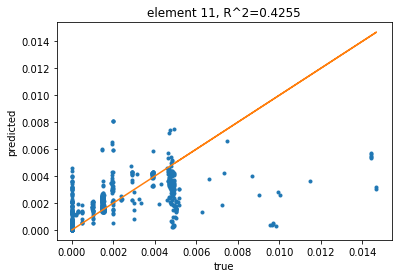

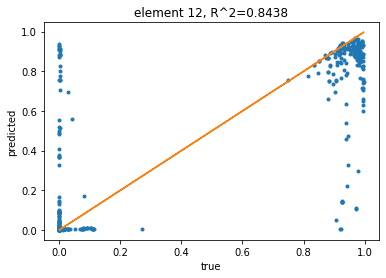

In [52]:
Y_train_true = trainY.numpy()
Y_true = testY.numpy()

Y_pred = normalize_results(Y_pred)
Y_train_pred = normalize_results(Y_train_pred)

print(f'MSE Train : {mean_squared_error(Y_train_true, Y_train_pred)}')    
print(f'MSE Test : {mean_squared_error(Y_true, Y_pred)}')    

print("The following graphs are plotted for the results on the test set")

for i in range(12):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()

Now we can do one more thing. To predict the proportion of an element X in the current material, we can consider all the properties as well as the proportion of elements other that X in the current material as the input features.

#### Model 3: Simple Neural Network that predicts proportion of each element in the material seperately using 17 input features (i.e. 6 property features + 11 elements proportion features)

In [54]:
# a simple training procedure with MSE loss and Adam optimiser
def train17to1(i, x, y,  max_iter=20000):
    # a simple MLP with three hidden layers and tanh activation
    m = nn.Sequential(nn.Linear(17, 17), nn.Tanh(), nn.Linear(17, 8), nn.Tanh(), nn.Linear(8, 1))
    m.double()
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(m.parameters())
    loss_hist = []
    R2_hist = []
    y_bar = torch.mean(y, 0)
       
    print(f'training for element {i}')

    for t in range(1, max_iter + 1):
        y_pred = m(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 1000 == 0:
            loss_hist.append(loss.detach())
            R2 = 1 - torch.sum((y - y_pred)**2, 0) / torch.sum((y - y_bar)**2, 0)
            R2 = torch.mean(R2)
            R2_hist.append(R2.detach())
            print(f'epoch: {t}, loss: {float(loss.item()):.8f}, R^2: {float(R2):.8f}')
            if len(loss_hist) > 2 and torch.abs((loss_hist[-1]-loss_hist[-2])/loss_hist[-1]) < 1e-6:
                break
    return m, loss_hist, R2_hist

In [55]:
Y_train_pred = np.empty((train_size, 12)) #2darray that stores prediction on training data
Y_pred = np.empty((size-train_size, 12)) #2darray that stores prediction on test data

curr_X = X_name + Y_name #names of features currently acting as input
for i in range(12):
    target = [Y_name[i]]
    curr_X.remove(target[0])
    trainX = torch.tensor(train_data[curr_X].values)
    testX = torch.tensor(test_data[curr_X].values)
    
    trainY = torch.tensor(train_data[target].values) #outputs for the current iteration
    testY = torch.tensor(test_data[target].values)
    
    m, loss_hist, R2_hist= train17to1(i+1, trainX, trainY, max_iter=10000)
    
    with torch.no_grad():
        y_train_pred_i = m(trainX).numpy()
    for j in range(train_size):
        Y_train_pred[j][i] = y_train_pred_i[j]
        
    with torch.no_grad():
        y_pred_i = m(testX).numpy()
    for j in range(size-train_size):
        Y_pred[j][i] = y_pred_i[j]
        
    curr_X.extend(target)
    

training for element 1
epoch: 1000, loss: 0.00013238, R^2: 0.99930509
epoch: 2000, loss: 0.00006102, R^2: 0.99967969
epoch: 3000, loss: 0.00003513, R^2: 0.99981557
epoch: 4000, loss: 0.00001983, R^2: 0.99989590
epoch: 5000, loss: 0.00001200, R^2: 0.99993701
epoch: 6000, loss: 0.00000735, R^2: 0.99996143
epoch: 7000, loss: 0.00000410, R^2: 0.99997850
epoch: 8000, loss: 0.00000562, R^2: 0.99997052
epoch: 9000, loss: 0.00000191, R^2: 0.99998997
epoch: 10000, loss: 0.00000120, R^2: 0.99999372
training for element 2
epoch: 1000, loss: 0.00040589, R^2: 0.92882494
epoch: 2000, loss: 0.00013275, R^2: 0.97672130
epoch: 3000, loss: 0.00004108, R^2: 0.99279619
epoch: 4000, loss: 0.00000785, R^2: 0.99862326
epoch: 5000, loss: 0.00000252, R^2: 0.99955833
epoch: 6000, loss: 0.00000144, R^2: 0.99974832
epoch: 7000, loss: 0.00000172, R^2: 0.99969780
epoch: 8000, loss: 0.00000077, R^2: 0.99986541
epoch: 9000, loss: 0.00000063, R^2: 0.99988883
epoch: 10000, loss: 0.00000055, R^2: 0.99990326
training for

MSE Train : 1.514125999635563e-06
MSE Test : 1.9746235946183298e-06
The following graphs are plotted for the results on the test set


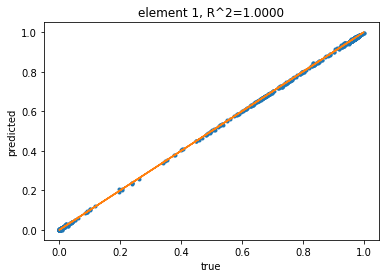

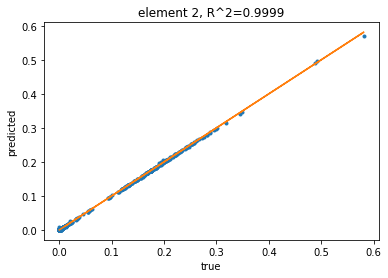

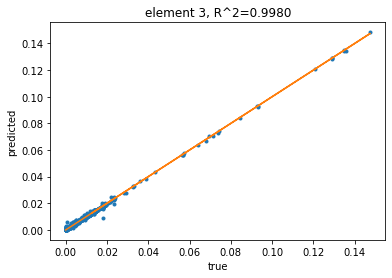

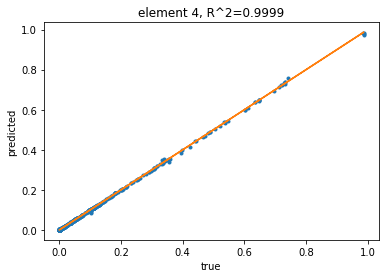

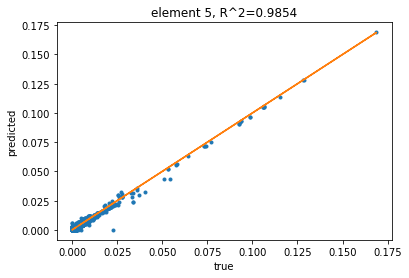

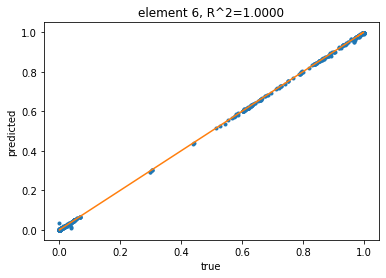

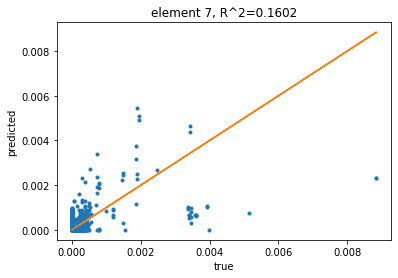

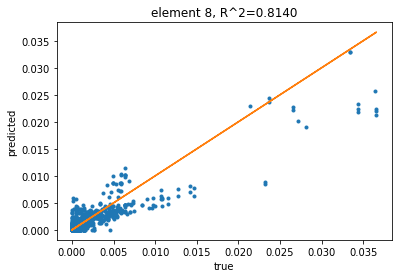

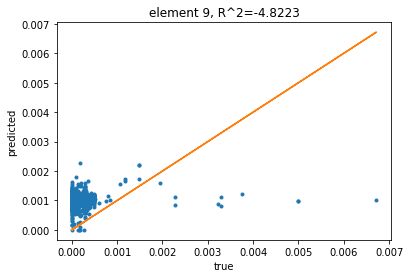

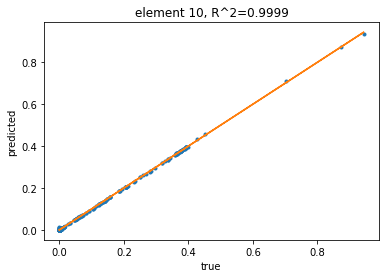

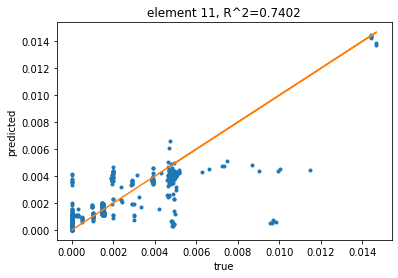

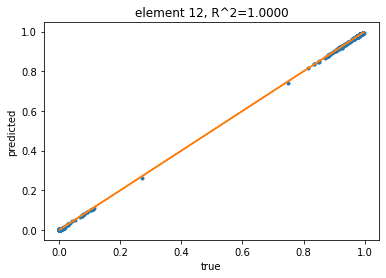

In [56]:
trainY = torch.tensor(train_data[Y_name].values) #overall output
testY = torch.tensor(test_data[Y_name].values)

Y_train_true = trainY.numpy()
Y_true = testY.numpy()

Y_pred = normalize_results(Y_pred)
Y_train_pred = normalize_results(Y_train_pred)

print(f'MSE Train : {mean_squared_error(Y_train_true, Y_train_pred)}')    
print(f'MSE Test : {mean_squared_error(Y_true, Y_pred)}')   

print("The following graphs are plotted for the results on the test set")

for i in range(12):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()

#### Model 4: Linear Regression

In [57]:
trainX = train_data[X_name]
testX = test_data[X_name]
trainY = train_data[Y_name]
testY = test_data[Y_name]

In [58]:
def trainRegressor(x, y):
    m = LinearRegression()
    m.fit(x, y)
    return m

MSE Train : 0.010430921930162951
MSE Test : 0.011138695820286794
The following graphs are plotted for the results on the test set


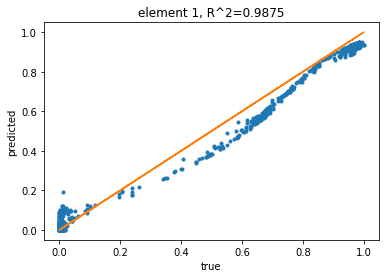

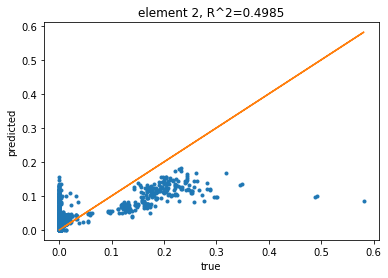

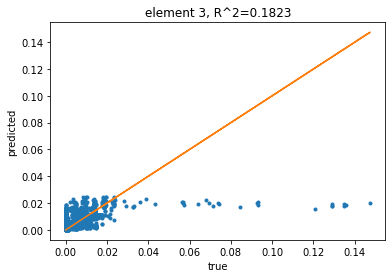

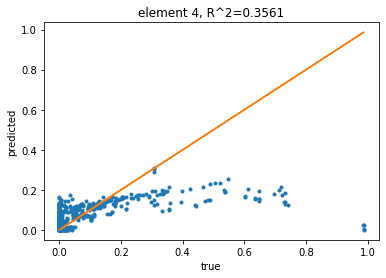

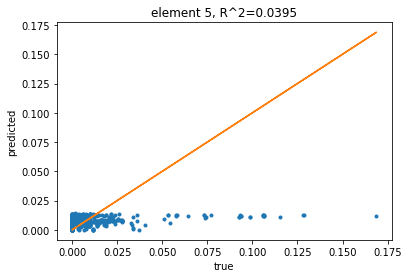

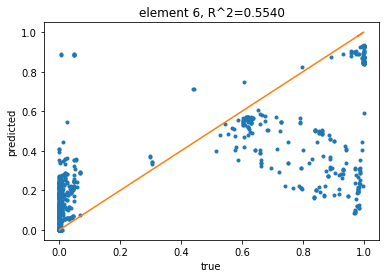

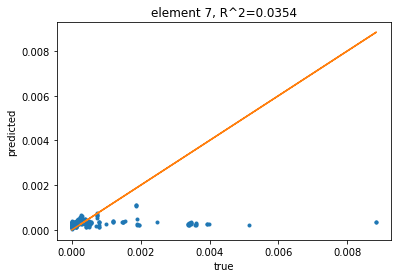

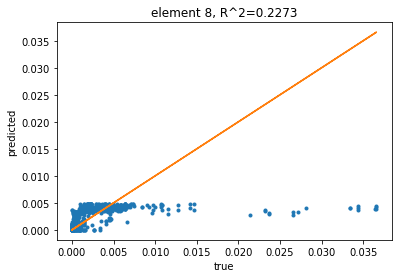

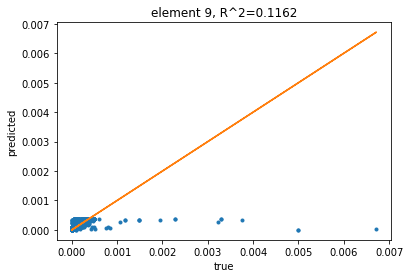

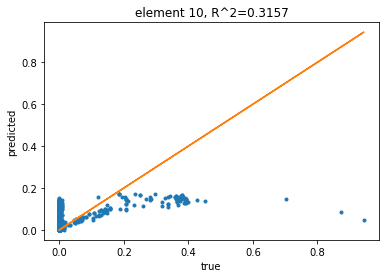

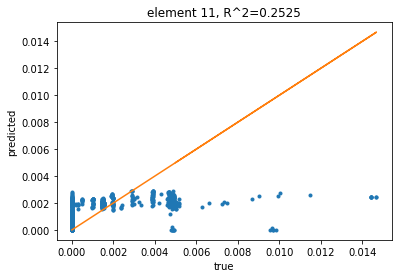

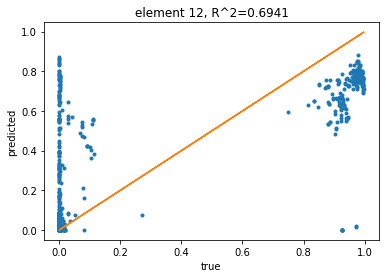

In [59]:
m = trainRegressor(trainX, trainY)

Y_train_pr = m.predict(trainX)
Y_test_pr = m.predict(testX)

Y_train_pr = normalize_results(Y_train_pr)
Y_test_pr = normalize_results(Y_test_pr)

print(f'MSE Train : {mean_squared_error(trainY, Y_train_pr)}')    
print(f'MSE Test : {mean_squared_error(testY, Y_test_pr)}')   

Y_true = np.array(testY)
Y_pred = np.array(Y_test_pr)

print("The following graphs are plotted for the results on the test set")

for i in range(12):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()

#### Model 5: K Nearest Neighbour Regression

In [60]:
def train_KNN(x, y):
    m = KNeighborsRegressor()
    m.fit(x, y)
    return m

MSE Train : 0.003523207416989337
MSE Test : 0.005855863537731615
The following graphs are plotted for the results on the test set


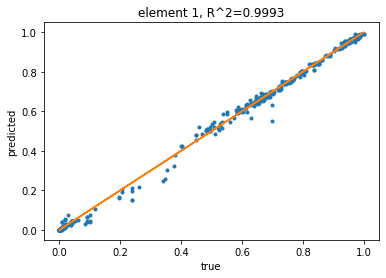

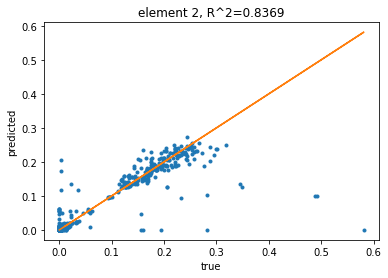

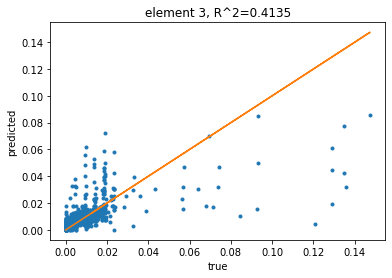

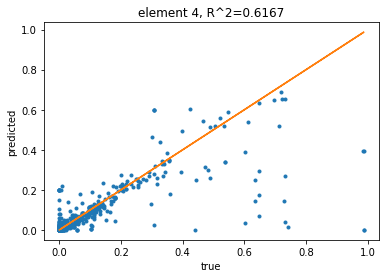

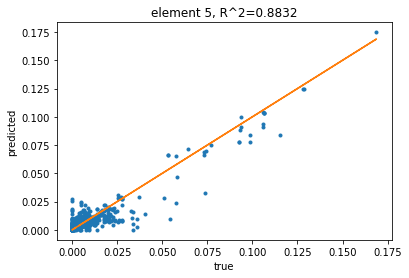

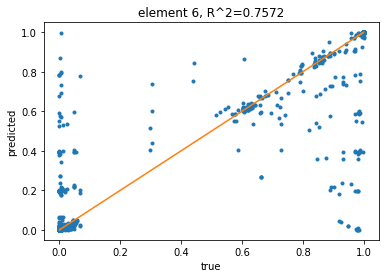

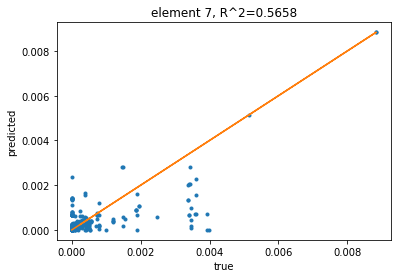

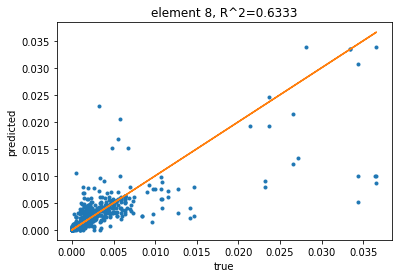

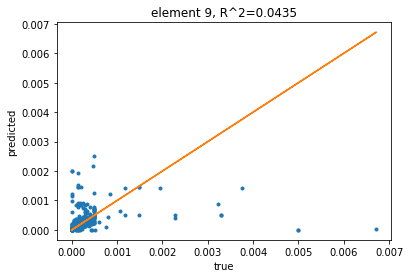

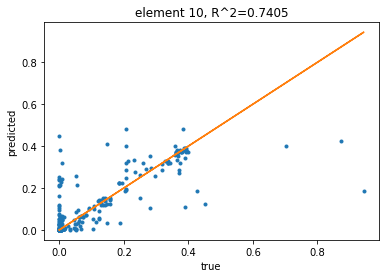

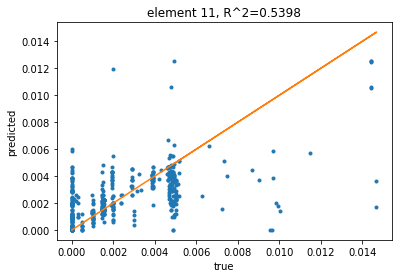

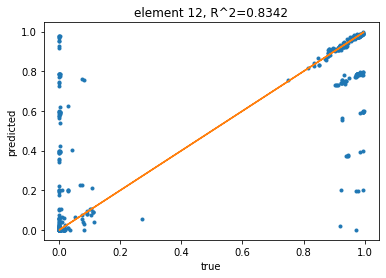

In [61]:
m = train_KNN(trainX, trainY)

Y_train_pr = m.predict(trainX)
Y_test_pr = m.predict(testX)

Y_train_pr = normalize_results(Y_train_pr)
Y_test_pr = normalize_results(Y_test_pr)

print(f'MSE Train : {mean_squared_error(trainY, Y_train_pr)}')    
print(f'MSE Test : {mean_squared_error(testY, Y_test_pr)}')    

Y_true = np.array(testY)
Y_pred = np.array(Y_test_pr)

print("The following graphs are plotted for the results on the test set")

for i in range(12):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()